#<span style="font-size: 1.6em;">Regressão linear
---
##Table of Contents
###1. Teoria
###2. Exemplos
    2.1. Encontrar o tempo de meia-vida de um radioisótopo e identificar o elemento
    2.2. Encontrar a aceleração da gravidade
    2.3. Dimensão fractal
    2.4. Encontrar as áreas do cérebro "ativas" durante um experimento
###3. Regularização
    3.1. Exemplo
        3.1.1. Regressão polinomial
        3.1.2. *Ridge regression* = regularização de Tikhonov
        3.1.3. LASSO

<hr style="height:2pt;" />

# Teoria

Modelo linear: $\mathbf{Y} = \mathbf{X} \mathbf{\beta} + \mathbf{\epsilon}$
- $\mathbf{Y}$: vetor $n \times 1$ de observações da variável independente
- $\mathbf{X}$: matriz $n \times k$ das variáveis independentes
- $\mathbf{\beta}$: vetor $n \times 1$ dos parâmetros desconhecidos
- $\mathbf{\epsilon}$: vetor $n \times 1$ dos erros

Método dos mínimos quadrados: encontrar $\hat{\beta}$ que minimiza $J = \sum_\limits{i} e_i^2$, onde $\mathbf{e} = \mathbf{Y} - \mathbf{X}\mathbf{\hat{\beta}} \Rightarrow \mathbf{0} = \frac{\partial J}{\partial \hat{\mathbf{\beta}}} = \frac{\partial (\mathbf{e}^T \mathbf{e})}{\partial \hat{\mathbf{\beta}}}$

A solução é $\mathbf{X}^T \mathbf{X} \mathbf{\hat{\beta}} = \mathbf{X}^T \mathbf{Y} \Rightarrow \boxed{\mathbf{\hat{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{Y}}$

- Valor esperado: $\mathrm{E}[\mathbf{\hat{\beta}}] = \mathrm{E}[\mathbf{\beta}]$
- Variância: $\mathrm{Var}[\mathbf{\hat{\beta}}] = \sigma^2 (\mathbf{X}^T \mathbf{X})^{-1}$
- Para estimar $\sigma^2$: $\hat{\sigma}^2 = \mathbf{e}^T \mathbf{e} / (n-k)$
- Graus de liberdade: tr$[\mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T]$

Para teste de hipótese, se $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbb{1}) \Rightarrow \mathbf{\hat{\beta}} \sim \mathcal{N}(\mathbf{\beta}, \sigma^2 (\mathbf{X}^T \mathbf{X})^{-1})$

Referência: http://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf

In [1]:
# Initializar pacotes

import numpy as np
import pandas as pd
from scipy import stats

# Display
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

<hr style="height:2pt;" />

#Exemplos

##Encontrar o tempo de meia-vida de um radioisótopo e identificar o elemento

Modelo: Atividade em decaimentos por segundo é $A(t) = A_0 \exp{(-\lambda t)}$, onde $\lambda$ é a taxa de decaimento e $A_0 = \lambda N_0$ ($N_0$ é o número de partículas em $t = 0$)

A meia-vida pode ser encontrada por: $T_{1/2} = \frac{\ln(2)}{\lambda}$.

Dada a atividade de decaimento de um elemento ao longo do tempo, encontre sua meia-vida.

Se possível, encontre o elemento. O decaimento é do tipo beta-menos (libera um elétron e um neutrino, e gera um elemento com um próton a mais).

In [2]:
t = [0, 5, 10, 15] # dias
A = [3.215E12, 3.214E12, 3.213E12, 3.212E12] # decaimento/s

print 'Conjunto de dados:'
display(pd.DataFrame(data=zip(t, A), columns=['t (dias)', 'A (Bq)']))

Conjunto de dados:


,t (dias),A (Bq)
0,0,3.215000e+12
1,5,3.214000e+12
2,10,3.213000e+12
3,15,3.212000e+12


In [3]:
# É necessário linearizar a equação: ln(A) = ln(A0) - lambda t => y = a + b t, y=ln(A), b=-lambda

X = np.matrix(data=zip(np.ones_like(t), t))
Y = np.log(A)

XTXinv = (np.dot(X.T, X)).I
Y.resize([len(Y),1]) # garante que é um vetor coluna
#beta = np.dot(np.dot(XTXinv, X.T), Y)
beta = reduce(np.dot, [XTXinv, X.T, Y])
print 'X ='
print X
print ''
print '(X^T X)^(-1) ='
print XTXinv
print ''
print 'beta ='
print beta
print ''
print 'Meia-vida = %.2f anos' %(np.log(2) / (-beta[1, 0]) / 365.25) # a unidade de lambda é a mesma de t
print ''
print 'Um elemento cuja meia-vida de decaimento beta-menos é similar é o césio-137 (meia-vida de 30.17 anos)'

X =
[[ 1  0]
 [ 1  5]
 [ 1 10]
 [ 1 15]]

(X^T X)^(-1) =
[[ 0.7   -0.06 ]
 [-0.06   0.008]]

beta =
[[  2.87988485e+01]
 [ -6.22374399e-05]]

Meia-vida = 30.49 anos

Um elemento cuja meia-vida de decaimento beta-menos é similar é o césio-137 (meia-vida de 30.17 anos)


<hr style="height:1pt;" />

##Encontrar a aceleração da gravidade

Modelo: $T = 2\pi\sqrt{\frac{L}{g}}$, onde $T$ é o período de um pêndulo simples, $L$ é o comprimento do pêndulo e $g$ é a aceleração da gravidade.

In [4]:
T = [0.64, 0.88, 1.43, 1.51] # em segundos
L = [.10, .20, .50, .60] # em metros

print 'Conjunto de dados:'
display(pd.DataFrame(data=zip(T, L), columns=['T (s)', 'L (m)']))

Conjunto de dados:


,T (s),L (m)
0,0.64,0.1
1,0.88,0.2
2,1.43,0.5
3,1.51,0.6


In [5]:
# É necessário linearizar a equação: T^2 = (2pi)^2 * L / g => y = a x, y=T^2, x=L, a=(2pi)^2/g

X = np.matrix(data=zip(np.ones_like(L), L))
Y = np.square(T)

XTXinv = (np.dot(X.T, X)).I
Y.resize([len(Y),1])
#beta = np.dot(np.dot(XTXinv, X.T), Y)
beta = reduce(np.dot, [XTXinv, X.T, Y])
print 'X ='
print X
print ''
print '(X^T X)^(-1) ='
print XTXinv
print ''
print 'beta ='
print beta
print ''
print 'g = %.2f m/s^2' %(4*np.pi**2/beta[1,0])

X =
[[ 1.   0.1]
 [ 1.   0.2]
 [ 1.   0.5]
 [ 1.   0.6]]

(X^T X)^(-1) =
[[ 0.97058824 -2.05882353]
 [-2.05882353  5.88235294]]

beta =
[[ 0.02213235]
 [ 3.87176471]]

g = 10.20 m/s^2


<hr style="height:1pt;" />

##Dimensão fractal

A dimensão fractal de um conjunto é um valor que diz o quão densamente um conjunto ocupa o espaço métrico em que ele existe. Ela pode assumir valores fracionários e está relacionada com o grau de complexidade de uma forma.

Relação entre a massa e a dimensão de medida:
- Para uma barra uniforme: $m = \lambda D$, onde $\lambda$ é a densidade linear de massa e $D$ é comprimento da barra
- Para uma chapa quadrada uniforme: $m = \sigma D^2$, onde $\lambda$ é a densidade superficial de massa
- Para uma esfera uniforme: $m = \rho \frac{4\pi}{3} D^3$, onde $\lambda$ é a densidade volumétrica de massa

Modelo: $m = k D^d$

Calcular a dimensão fractal de uma bola de papel amassada.

In [6]:
m = [112, 56.6, 55.5, 25.9, 30.0, 15.2, 14.8, 7.57, 7.71, 3.85, 3.89, 2.05, 1.85] # em gramas
D = [27.5, 20.0, 19.0, 14.5, 15.5, 10.0, 9.0, 7.8, 6.5, 6.0, 4.8, 4.9, 4.8 ] # diâmetro em cm

print 'Conjunto de dados:'
display(pd.DataFrame(data=zip(m, D), columns=['m (g)', 'D (cm)']))

Conjunto de dados:


,m (g),D (cm)
0,112.00,27.5
1,56.60,20.0
2,55.50,19.0
3,25.90,14.5
4,30.00,15.5
5,15.20,10.0
6,14.80,9.0
7,7.57,7.8
8,7.71,6.5
9,3.85,6.0


In [7]:
# É necessário linearizar a equação: m=kD^d => log(m) = log(k) + d log(D) => y=b+ax, y=log(m), x=log(D), a=d, b=log(k)

X = np.matrix(data=zip(np.ones_like(D), np.log(D)))
Y = np.log(m)

XTXinv = (np.dot(X.T, X)).I
Y.resize([len(Y),1])
#beta = np.dot(np.dot(XTXinv, X.T), Y)
beta = reduce(np.dot, [XTXinv, X.T, Y])
print 'X ='
print X
print ''
print '(X^T X)^(-1) ='
print XTXinv
print ''
print 'beta ='
print beta
print ''
print 'Dimensão fractal do papel = %.2f' %(beta[1,0])

X =
[[ 1.          3.314186  ]
 [ 1.          2.99573227]
 [ 1.          2.94443898]
 [ 1.          2.67414865]
 [ 1.          2.74084002]
 [ 1.          2.30258509]
 [ 1.          2.19722458]
 [ 1.          2.05412373]
 [ 1.          1.87180218]
 [ 1.          1.79175947]
 [ 1.          1.56861592]
 [ 1.          1.58923521]
 [ 1.          1.56861592]]

(X^T X)^(-1) =
[[ 1.27155246 -0.52443253]
 [-0.52443253  0.23022159]]

beta =
[[-2.36594635]
 [ 2.15125495]]

Dimensão fractal do papel = 2.15


<hr style="height:1pt;" />

##Encontrar as áreas do cérebro "ativas" durante um experimento

Um voluntário foi instruído a mover sua mão direita em 3 blocos de 20 segundos cada, intercalados com blocos de repouso de 20 segundos cada:

repouso (0-20 s) - movimento (20-40 s) - repouso (40-60 s) - movimento (60-80 s) - repouso (80-100 s) - movimento (100-120 s) - repouso (120-140 s)

A medida é feita com aparelho de ressonância magnética a cada 2 segundos. Encontrar quais voxels estavam ativos durante o movimento da mão.

Suposições: ruído gaussiano i.i.d; drift linear no sinal

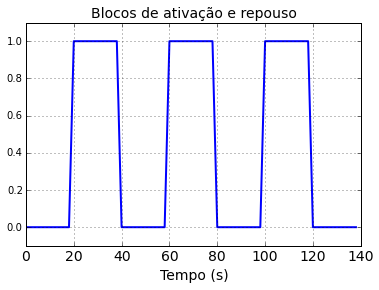

In [8]:
# Parâmetros da aquisição:
TR = 2 # tempo de repetição da aquisição das imagens (em segundos)
N = 140 / TR # número de instantes
blocos = .5*(np.sign(-np.sin(2*np.pi/20*(np.arange(0, N) + 1))) + 1)

fontsize = 14
plt.plot(TR*np.arange(N), blocos, linewidth=2)
plt.xlabel('Tempo (s)', fontsize=fontsize)
plt.title(u'Blocos de ativação e repouso', fontsize=fontsize)
plt.ylim([-.1, 1.1]);
plt.tick_params(axis='x', labelsize=fontsize)
plt.grid()

In [9]:
# Normalmente são em torno de 250.000 voxels, mas vamos fazer com números simbólicos

# Criar dados simulados:
Nvox = 25
Nvox_ativ = 3
std_ruido = .5

ruido_ativ = np.random.RandomState(seed=4).normal(0, std_ruido, size=(N, Nvox_ativ))
blocos_ativ = (np.array([blocos]*Nvox_ativ).transpose() + ruido_ativ)
sinal = np.random.RandomState(seed=2).normal(0, std_ruido, size=(N, Nvox-Nvox_ativ))
sinal = np.hstack((sinal, blocos_ativ))
drift = np.linspace(start=0, stop=sinal.max()/2, num=N)
sinal = sinal + np.array([drift]*sinal.shape[1]).transpose()

print 'Razão sinal-ruído = %.2f' %(1/std_ruido)
print 'Tamanho da matriz dos dados =', sinal.shape
print 'Número de voxels "ativos" =', Nvox_ativ

Razão sinal-ruído = 2.00
Tamanho da matriz dos dados = (70, 25)
Número de voxels "ativos" = 3


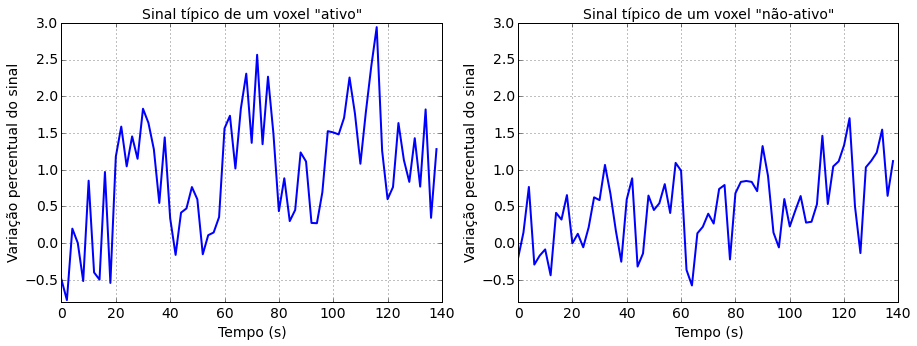

In [10]:
fontsize = 14
ylim = [-.8, 3]

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(TR*np.arange(N), sinal[:, Nvox-1], linewidth=2)
plt.xlabel('Tempo (s)', fontsize=fontsize)
plt.ylabel(u'Variação percentual do sinal', fontsize=fontsize)
plt.title(u'Sinal típico de um voxel "ativo"', fontsize=fontsize)
plt.ylim(ylim)
plt.tick_params(axis='both', labelsize=fontsize)
plt.grid()

plt.subplot(122)
plt.plot(TR*np.arange(N), sinal[:, 0], linewidth=2)
plt.xlabel('Tempo (s)', fontsize=fontsize)
plt.ylabel(u'Variação percentual do sinal', fontsize=fontsize)
plt.title(u'Sinal típico de um voxel "não-ativo"', fontsize=fontsize)
plt.ylim(ylim)
plt.tick_params(axis='both', labelsize=fontsize)
plt.grid()

In [11]:
# GLM (modelo linear geral): Y = X beta (para cada voxel)
# X: 1 coluna com valores 1; 1 coluna com experimento apresentado; 1 coluna com drift linear
# Quero descobrir qual voxel tem parâmetro beta associado à coluna acima significantemente diferente de zero

X = np.matrix(np.vstack((np.ones_like(blocos), blocos, np.linspace(start=-1, stop=1, num=N))).transpose()) # chamada de "design matrix"
XTXinv = (np.dot(X.T, X)).I
k = X.shape[1] # número de parâmetros
c = np.array([0, 1, 0]) # chamada de "matriz de contraste"; cada número corresponde a uma coluna
# para procurar "desativação" no cérebro, utiliza-se: c = np.array([0, -1])

print 'X ='
print X
print ''
print '(X^T X)^(-1) ='
print XTXinv
print ''

X =
[[ 1.          0.         -1.        ]
 [ 1.          0.         -0.97101449]
 [ 1.          0.         -0.94202899]
 [ 1.          0.         -0.91304348]
 [ 1.          0.         -0.88405797]
 [ 1.          0.         -0.85507246]
 [ 1.          0.         -0.82608696]
 [ 1.          0.         -0.79710145]
 [ 1.          0.         -0.76811594]
 [ 1.          0.         -0.73913043]
 [ 1.          1.         -0.71014493]
 [ 1.          1.         -0.68115942]
 [ 1.          1.         -0.65217391]
 [ 1.          1.         -0.62318841]
 [ 1.          1.         -0.5942029 ]
 [ 1.          1.         -0.56521739]
 [ 1.          1.         -0.53623188]
 [ 1.          1.         -0.50724638]
 [ 1.          1.         -0.47826087]
 [ 1.          1.         -0.44927536]
 [ 1.          0.         -0.42028986]
 [ 1.          0.         -0.39130435]
 [ 1.          0.         -0.36231884]
 [ 1.          0.         -0.33333333]
 [ 1.          0.         -0.30434783]
 [ 1.          0.    

In [12]:
# Procurando os voxels ativos

P = np.zeros(Nvox)
for vv in range(Nvox):

    Y = sinal[:, vv]
    Y = Y.reshape([N, 1])
    beta = reduce(np.dot, [XTXinv, X.T, Y])
#     print ''
#     print '--------------------------------'
#     print 'Voxel =', vv
#     print ''
#     print '  beta ='
#     print beta
#     print ''

    # Erro e variância
    e = Y - np.dot(X, beta)
    sigma2 = np.dot(e.T, e)[0, 0]
    Var_beta = (sigma2 * XTXinv) / (N-k)
#     print '  sigma^2 =', sigma2
#     print '  Var[beta] ='
#     print Var_beta

#     print ''
#     print '  O voxel está ativo?'
    T = np.dot(c.T, beta)[0, 0] / np.dot(np.dot(c.T, Var_beta), c)[0, 0]
    P[vv] = stats.t.sf(T, N-k) # teste unicaudal
#     print '  T = %.2f (P = %.3g)' %(T, P[vv])

In [13]:
thresh = 10E-10
print ' [Voxel, P]:'
pprint.pprint([['%02d' %vv, '%.2g' %PP] for vv, PP in enumerate(P) if PP<thresh])

 [Voxel, P]:
[['04', '6.2e-10'],
 ['09', '2.3e-17'],
 ['16', '7.4e-10'],
 ['22', '2.3e-58'],
 ['23', '2.7e-69'],
 ['24', '5.2e-72']]


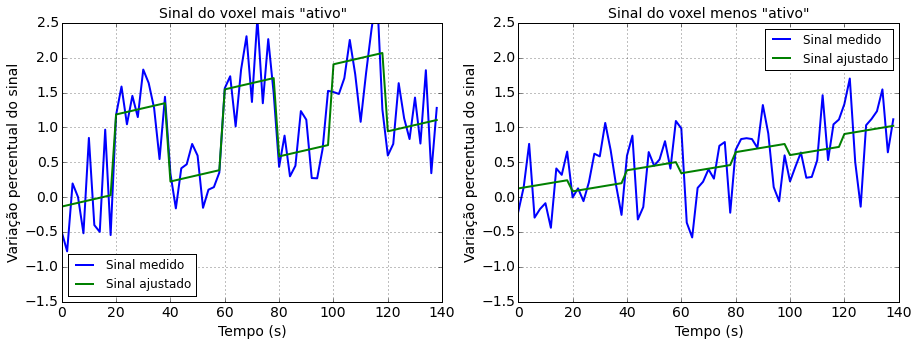

In [14]:
# Vamos olhar o sinal dos voxels mais e menos significativos:

plt.figure(figsize=(15,5))

Y = sinal[:, P.argmin()]
Y = Y.reshape([N, 1])
beta = reduce(np.dot, [XTXinv, X.T, Y])

plt.subplot(121)
plt.plot(TR*np.arange(N), Y, linewidth=2, label='Sinal medido')
plt.plot(TR*np.arange(N), np.dot(X, beta), linewidth=2, label='Sinal ajustado')
plt.xlabel('Tempo (s)', fontsize=fontsize)
plt.ylabel(u'Variação percentual do sinal', fontsize=fontsize)
plt.title(u'Sinal do voxel mais "ativo"', fontsize=fontsize)
plt.ylim([-1.5, 2.5])
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(loc='best')
plt.grid();



Y = sinal[:, P.argmax()]
Y = Y.reshape([N, 1])
beta = reduce(np.dot, [XTXinv, X.T, Y])

plt.subplot(122)
plt.plot(TR*np.arange(N), Y, linewidth=2, label='Sinal medido')
plt.plot(TR*np.arange(N), np.dot(X, beta), linewidth=2, label='Sinal ajustado')
plt.xlabel('Tempo (s)', fontsize=fontsize)
plt.ylabel(u'Variação percentual do sinal', fontsize=fontsize)
plt.title(u'Sinal do voxel menos "ativo"', fontsize=fontsize)
plt.ylim([-1.5, 2.5])
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(loc='best')
plt.grid();

Esse é o método mais convencional para se encontrar as áreas "ativas" do cérebro.

<hr style="height:2pt;" />

# Regularização

Com a regularização, adiciona-se informação para resolver problemas mal-condicionados ou para evitar *overfitting*.

Modelo linear: $\mathbf{Y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}$

Encontrar $\hat{\beta}$ que minimiza $J = \sum_i e_i^2$, onde $\mathbf{e} \equiv \mathbf{Y} - \mathbf{X}\boldsymbol{\hat{\beta}}$, com a restrição $\|\beta\|_p \equiv \left(\sum_\limits{i}{|\beta_i|^p}\right)^{1/p} < L$

Portanto, modelos com valores extremos dos parâmetros são penalizados.

O problema é equivalente a minimizar $J = \sum_i e_i^2 + \lambda (\|\beta\|_p)^p$, onde $\lambda$ é um hiper-parâmetro que precisa ser otimizado (normalmente por validação cruzada). Casos extremos:
- $\lambda \rightarrow 0 \Rightarrow$ mínimos quadrados
- $\lambda \rightarrow \infty \Rightarrow \boldsymbol{\beta} \rightarrow \mathbf{0}$

Em *machine learning*, os métodos mais comuns são regularização $L_1$ (LASSO) e $L_2$ (*ridge regression* ou regularização de Tikhonov). LASSO produz modelos esparsos (parâmetros nulos), sendo útil para seleção de *features*.

Para $p = 2$ (*ridge regression*), existe um solução analítica: $\mathbf{\hat{\beta}} = (\mathbf{X}^T \mathbf{X} + \lambda\mathbb{1})^{-1} \mathbf{X}^T \mathbf{Y}$. Cuidado: por convenção, assume-se que
- as colunas de $\mathbf{X}$ têm média 0 e variância 1 (*Z-transform*)
- $\mathbf{Y}$ tem média 0

Em *elastic net*, são combinadas as normas $L_!$ e $L_2$: 

$J = \|\mathbf{Y} - \mathbf{X}\boldsymbol{\hat{\beta}}\|^2 + \lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2$

##Exemplo

Fonte: http://www.datarobot.com/blog/regularized-linear-regression-with-scikit-learn/

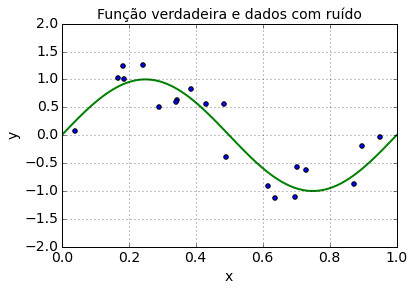

In [15]:
fontsize = 14

np.random.seed(9)

def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8) # vamos assumir que "test" é o conjunto de validação (também chamado de desenvolvimento), e que o conjunto de teste na verdade não nos foi fornecido

# plot
ax = plt.gca()
ax.plot(x_plot, f(x_plot), color='green', linewidth=2)
ax.scatter(X_train, y_train, s=20)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_xlabel('x', fontsize=fontsize)
ax.set_ylabel('y', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_title(u'Função verdadeira e dados com ruído', fontsize=fontsize)
ax.grid()

###Regressão polinomial

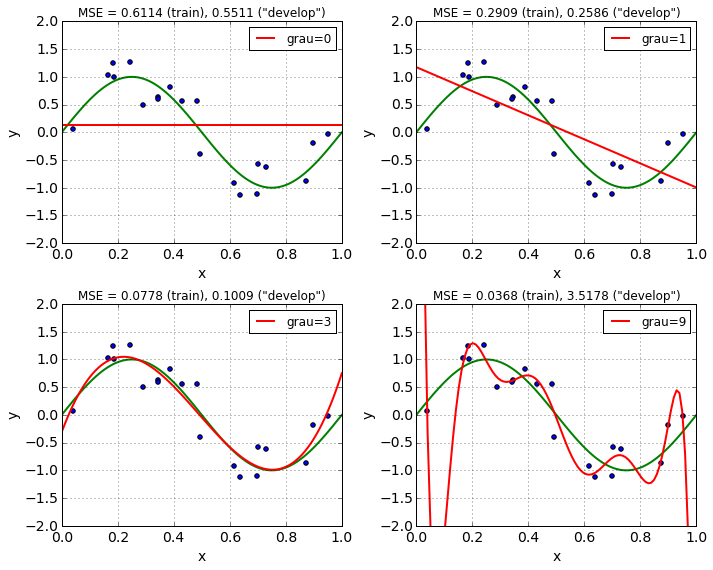

In [16]:
def plot_approximation(est, ax, label=None, fontsize=14):
    """Plot the approximation of ``est`` on axis ``ax``."""
    ax.plot(x_plot, f(x_plot), color='green', linewidth=2)
    ax.scatter(X_train, y_train, s=20)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label, linewidth=2)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_xlabel('x', fontsize=fontsize)
    ax.set_ylabel('y', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.legend(loc='upper right')  #, fontsize='small')
    ax.set_title('MSE = %.4f (train), %.4f ("develop")' %(mean_squared_error(y_train, est.predict(X_train)), mean_squared_error(y_test, est.predict(X_test))))
    ax.grid()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# fit different polynomials and plot approximations
for ax, degree in zip(axes.ravel(), [0, 1, 3, 9]):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    plot_approximation(est, ax, label='grau=%d' % degree, fontsize=14)

plt.tight_layout()

Conforme aumenta o grau do polinômio, o erro quadrático médio (MSE) diminui para o conjunto de treinamento, mas é visível o *overfitting* para grau = 9 (o erro aumenta para o conjunto de desenvolvimento). Vamos verificar isso.

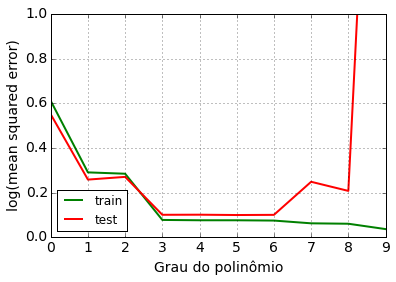

In [17]:
fontsize = 14

train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

plt.plot(np.arange(10), train_error, color='green', label='train', linewidth=2)
plt.plot(np.arange(10), test_error, color='red', label='test', linewidth=2)
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)', fontsize=fontsize)
plt.xlabel(u'Grau do polinômio', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.grid()
plt.legend(loc='lower left');

Agora fica claro o *overfitting*: quando aumenta o grau do polinômio (relacionado com a complexidade do modelo), o erro no conjunto de treinamento cai, mas o erro no conjunto de teste passa a crescer a partir de grau 6. Uma escolha visual indica que o grau do polinômio deve estar entre 3 e 6 (inclusive).

###*Ridge regression* = regularização de Tikhonov

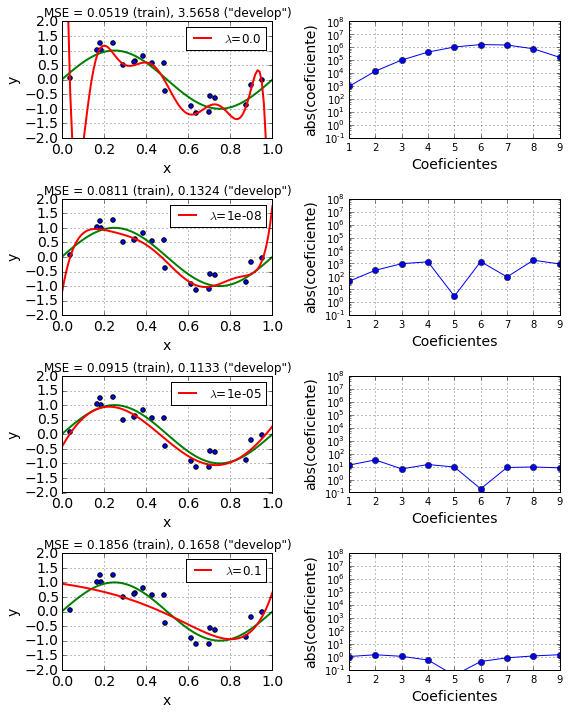

In [18]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))

def plot_coefficients(est, ax, label=None, yscale='log', fontsize=14):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coeficiente)', fontsize=fontsize)
    ax.set_xlabel('Coeficientes', fontsize=fontsize)
    ax.set_xlim((1, 9))
    ax.grid()

degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha, normalize=True))
    est.fit(X_train, y_train - y_train.mean())
    plot_approximation(est, ax_left, label='$\lambda$=%r' % alpha, fontsize=14)
    plot_coefficients(est, ax_right, label='Ridge($\lambda$=%r) coefficients' % alpha, fontsize=14)

plt.tight_layout()

Quanto maior o parâmetro $\lambda$, mais penalizados são os coeficientes. O MSE atinge valor mínimo quando $\lambda = 1 \times 10^{-5}$.

###LASSO

/Users/guilherme/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


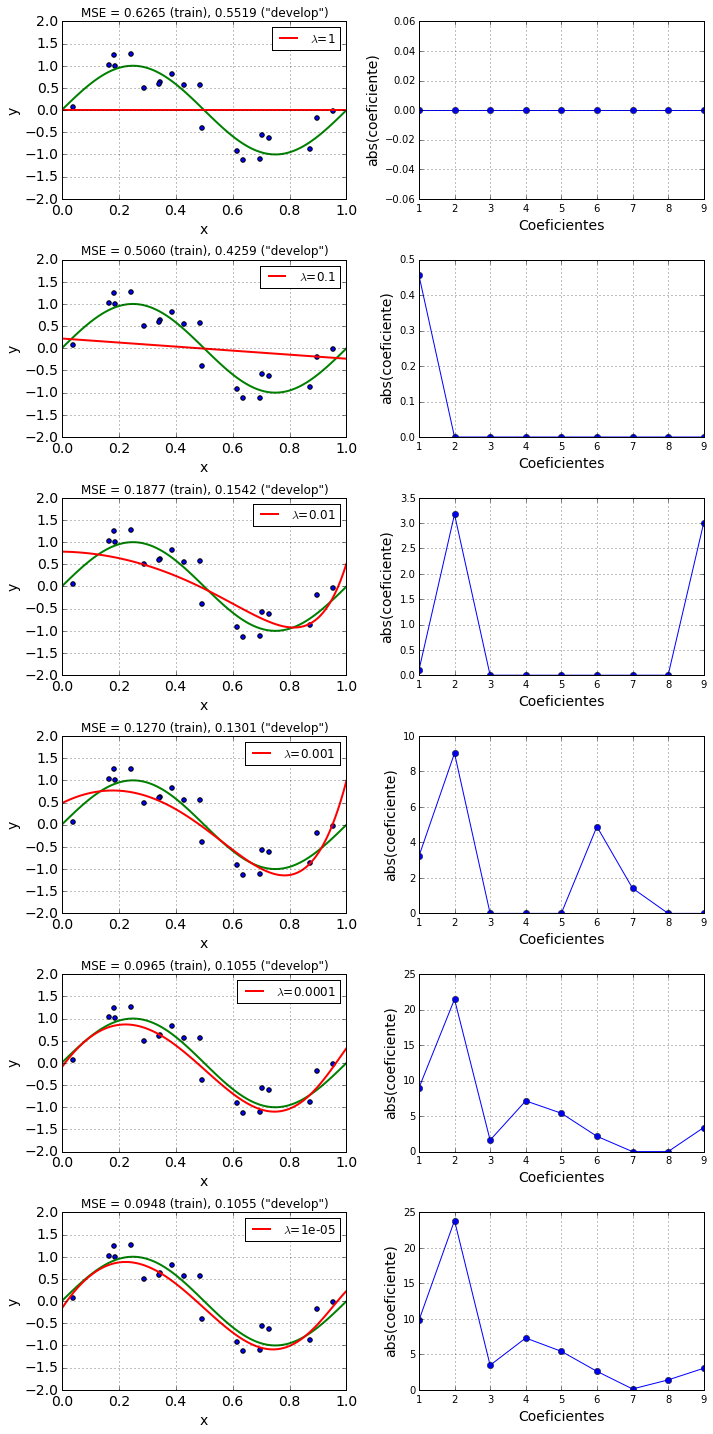

In [19]:
degree = 9
alphas = [10**(-e) for e in xrange(6)]
# For numerical reasons, using ``alpha = 0`` is with the Lasso object is not advised and you should prefer the LinearRegression object.

fig, ax_rows = plt.subplots(len(alphas), 2, figsize=(10, 20))

for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, normalize=True))
    est.fit(X_train, y_train - y_train.mean())
    plot_approximation(est, ax_left, label='$\lambda$=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso($\lambda$=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()